In [1]:
import logging
from pathlib import Path

import geojson
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
import numpy as np

from external.pyFIS import pyFIS

%matplotlib inline

In [2]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

# Get data
In this section we extract data from vaarweginformatie.nl using the pyFIS library. 

In [3]:
# Connect to FIS
FIS = pyFIS()

In [4]:
# Get all section (=vaarwegvakken) and sectionnodes
section = FIS.list_objects('section')  #.set_index('Id') 
maximumdimensions = FIS.list_objects('maximumdimensions')  #.set_index('Id')
navigability = FIS.list_objects('navigability')  #.set_index('Id')

maximumdimensions_columns = ['geometry', 'GeneralDepth', 'GeneralLength', 'GeneralWidth', 'Note',
       'SeaFairingDepth', 'PushedLength',
       'PushedWidth', 'GeneralHeight', 'SeaFairingLength', 'SeaFairingWidth',
       'CoupledLength', 'CoupledWidth', 'PushedDepth', 'WidePushedDepth',
       'CoupledDepth', 'WidePushedLength', 'WidePushedWidth',
       'SeaFairingHeight']

navigability_columns = ['geometry', 'Classification', 'Code', 'Description']


section = section.merge(maximumdimensions[maximumdimensions_columns], left_on='geometry', right_on='geometry', how='left', suffixes=('', '_maximumdimensions'))
section = section.merge(navigability[navigability_columns], left_on='geometry', right_on='geometry', how='left', suffixes=('', '_navigability'))


Removing 4 nan-geometries from dataset


In [5]:
# Remove sections that do not have an ID as start or end point (in the selection polygon this is only the end of the Linge)
# Alternative: Make up new node names for these locations and also add those locations to the section_node table
section = section[~section[['StartJunctionId', 'EndJunctionId']].isna().any(axis=1)]

In [6]:
section_node = FIS.list_objects('sectionjunction').set_index('Id')

In [7]:
b = FIS.merge_geotypes('bridge', 'opening')

In [8]:
# Get all bridges including openings
bridges = FIS.merge_geotypes('bridge', 'opening')

# Get all locks including chambesr
locks = FIS.merge_geotypes('lock', 'chamber')

In [9]:
def group_subobjects(bridges_selection, fieldname=None, type_selection='max'):

    if fieldname is not None:
        # Remove nans
        bridges_selection = bridges_selection[~bridges_selection[fieldname].isna()]

    # Only keep opening with the maximum HeightClosed
    if type_selection=='max':
        id_max_height = bridges_selection.groupby('Id')[fieldname].idxmax().values

        bridges_selection = bridges_selection.reindex(id_max_height)
        bridges_selection = bridges_selection.set_index('Id')
    else:
        print('Unknown criteria')
    return bridges_selection



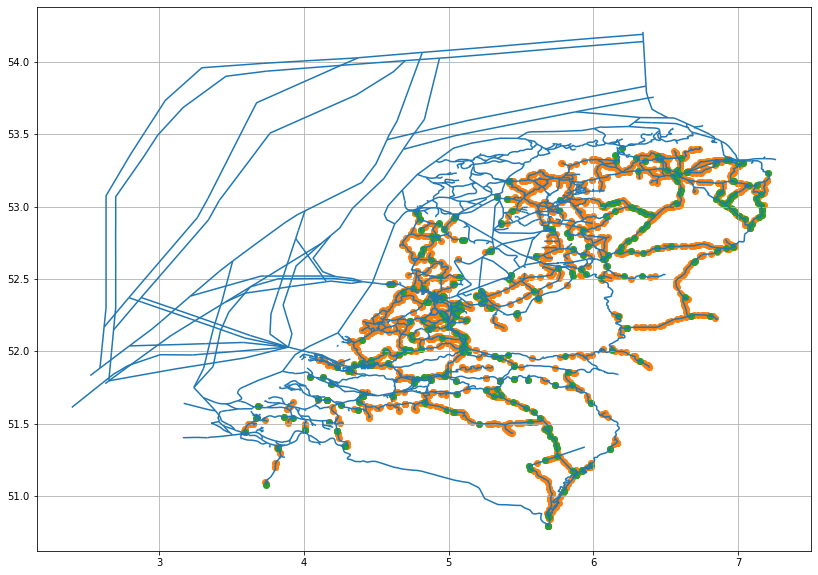

In [10]:
f, ax  = plt.subplots(figsize=(14,10))
section.plot(color='C0', ax=ax)
bridges.plot(c='C1', ax=ax)
locks.plot(c='C2', ax=ax)
ax.grid()



# Build network
Based on the geometry we can now define a more abstract graph. A graph representation is similar to a subway map. It does not store the exact locations but it does store the topological relations between all the locations. 

In [13]:
section['length'] = section.length.values
network = nx.from_pandas_edgelist(section, 'StartJunctionId', 'EndJunctionId', edge_attr=True)

In [14]:
# Add node properties
for n in network.nodes:
    network.nodes[n]['X'] = section_node.loc[n].geometry.x
    network.nodes[n]['Y'] = section_node.loc[n].geometry.y

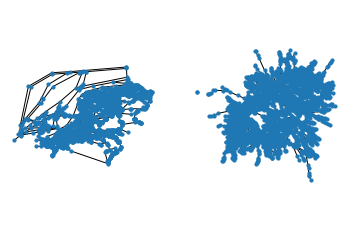

In [15]:
# this is the subway version of the corridor
fig, axes = plt.subplots(ncols=2)

spatial_pos = {
    k: (v['X'], v['Y']) 
    for k, v 
    in network.nodes.items()
}
nx.draw(
    network, 
    pos=spatial_pos, 
    node_size=10,
    ax=axes[0]
)
axes[0].axis('equal')

pos = nx.spring_layout(network, pos=spatial_pos, weight='Length', iterations=50)

nx.draw(
    network, 
    pos=pos, 
    node_size=10,
    ax=axes[1]
)
axes[1].axis('equal')
fig

# Now add bridges as nodes

I'm not sure if this was really necessary...

In [17]:
# Splitting the closest line at given point

def nearest_line(point, lines):
    # Returns index of the closest line to the point
    # point: Shapely Point
    # lines: Shapely Polylines
    d = np.full((len(lines)), fill_value=np.nan)
    for ii in range(len(lines)):
        d[ii] = point.distance(lines[ii])
    return np.argmin(d), np.min(d)

def chainage_on_line(point, line):
    # Find chainage of line closest to point
    # point: Shapely Point
    # lines: Shapely Polylines
    return line.project(point)
    
def cut(line, chainage):
    # Cuts a line in two at a distance from its starting point
    # point: Shapely Polyline
    # chainage: distance along line
    
    # if 0 or longer than line, return line
    if chainage <= 0.0 or chainage >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == chainage:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > chainage:
            cp = line.interpolate(chainage)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]



In [18]:
def split_lines_at_points(section_selection, bridges_selection, max_distance=0.002, prefix='B', 
                          node_start_columnname="StartJunctionId", node_end_columnname="EndJunctionId"):
    """
    section_selection: geodataframe of polylines
    bridges_selection: geodataframe of points where you want to polylines to split
    
    max_distance: maximum distance of point to line in order. When max_distance is exceeded, the point will be ignored
    prefix: the nodes will be split get a new of the index of 'bridge_selection' with this prefix
    
    node_start_columnname: in dataframe 'section_selection' name of start_node
    node_end_columnname: in dataframe 'section_selection' name of end_node
    
    """
    
    
    section_selection_with_bridges = section_selection.copy()
    for k, bridge in bridges_selection.iterrows():

        # abreviate
        b = bridge.geometry
        bridge_ID = f'{prefix}{k}'
        s = section_selection_with_bridges.geometry.values

        # Split closest section
        nearest_section, distance_to_nearest_section = nearest_line(b, s)
        if distance_to_nearest_section> max_distance: # If distance (in degree) it too large, apparently it's not near a section
            print(f'Too far from river, ignoring point (name: "{bridge.Name}")')
            continue

        chainage = chainage_on_line(b, s[nearest_section])

        # Chainage already on a node, no need to split
        if chainage == 0 or chainage == s[nearest_section].length:

            # Replace name of node, with name of bridge
            if chainage == 0:
                node_ID = section_selection_with_bridges.iloc[nearest_section][node_start_columnname]
            else:
                node_ID = section_selection_with_bridges.iloc[nearest_section][node_end_columnname]

            print(f'Renaming node {node_ID} to point {bridge_ID} (name: "{bridge.Name}")')
            section_selection_with_bridges[[node_start_columnname, node_end_columnname]] = section_selection_with_bridges[[node_start_columnname, node_end_columnname]].replace({node_ID: bridge_ID})
            continue

        split = cut(s[nearest_section], chainage)


        # Create new sections    
        section_old = section_selection_with_bridges.iloc[nearest_section]

        section_new_1 = section_old.copy()
        section_new_2 = section_old.copy()

        section_new_1['geometry'] = split[0]
        section_new_2['geometry'] = split[1]


        section_new_1[node_end_columnname] = bridge_ID
        section_new_2[node_start_columnname] = bridge_ID

        section_new_1.name = f'{section_old.name}_A'
        section_new_2.name = f'{section_old.name}_B'

        # Update DataFrame
        section_selection_with_bridges = section_selection_with_bridges.drop(section_old.name, axis='index')
        section_selection_with_bridges = section_selection_with_bridges.append(section_new_1)
        section_selection_with_bridges = section_selection_with_bridges.append(section_new_2)
    return section_selection_with_bridges


In [19]:
def build_network(section_selection_with_bridges_with_locks):
    section_selection_with_bridges_with_locks['length'] = section_selection_with_bridges_with_locks.length.values
    section_selection_with_bridges_with_locks['Wkt'] = [a.wkt for a in section_selection_with_bridges_with_locks.geometry]
    section_selection_with_bridges_with_locks = section_selection_with_bridges_with_locks.drop('geometry', axis=1)
    
    network = nx.from_pandas_edgelist(section_selection_with_bridges_with_locks, 'StartJunctionId', 'EndJunctionId', edge_attr=True)
    
    # Shorten names in case of shapefile export
#     section_selection_with_bridges_with_locks = section_selection_with_bridges_with_locks.rename(columns={'StartJunctionId': 'Start', 'EndJunctionId': 'End'})
#     network = nx.from_pandas_edgelist(section_selection_with_bridges_with_locks, 'Start', 'End', edge_attr=True)
    return network


In [21]:
def add_node_properties(network, gpd_nodes):
    """add information from gpd_nodes to the network (in place)"""
    for prefix, gpd in gpd_nodes.items():
        a = gpd.geometry.copy()
        if len(prefix):
            a.index = [f'{prefix}{b}' for b in a.index]
        
        nx.set_node_attributes(network, {k: v.wkt for k, v in a.to_dict().items()}, 'Wkt')
        nx.set_node_attributes(network, {k: v.x for k, v in a.to_dict().items()}, 'x')
        nx.set_node_attributes(network, {k: v.y for k, v in a.to_dict().items()}, 'y')
    return network
        

# Apply full scale

In [24]:
bridges_grouped = group_subobjects(bridges, fieldname='HeightClosed')
locks_grouped = group_subobjects(locks, fieldname='Id')

section_with_bridges = split_lines_at_points(section, bridges_grouped)
section_with_bridges_locks = split_lines_at_points(section_with_bridges, locks_grouped)

network = build_network(section_with_bridges_locks)
# network = add_node_properties(network, bridges_grouped, locks_grouped)



Renaming node 8861984.0 to point B4944 (name: "Hardwegbrug")
Renaming node 22638445.0 to point B5861 (name: "Brug in de weg Hatenboer")
Too far from river, ignoring point (name: "Neeroeteren, brug in Kanaalstraat")
Renaming node 8867838.0 to point B8846 (name: "Keersluisbrug (1)")
Too far from river, ignoring point (name: "Brug Eisden 2")
Too far from river, ignoring point (name: "Dilsen (B), brug in N771")
Too far from river, ignoring point (name: "Eisden I (B), brug in  N78")
Too far from river, ignoring point (name: "Lanklaar, voetbrug")
Too far from river, ignoring point (name: "Maasmechelen (B), fiets/voetbrug")
Renaming node 19440541.0 to point B34142 (name: "Leeuwenbrug")
Too far from river, ignoring point (name: "Rotem (B), brug")
Too far from river, ignoring point (name: "Maasmechelen (B), brug in de A2/E34")
Too far from river, ignoring point (name: "Rotem, voormalige spoorbrug")
Renaming node 19119695.0 to point B38227 (name: "Franekerpoortsbrug")
Too far from river, ignorin

In [ ]:
nx.write_yaml(network, 'result/export_full_network.yaml')


In [ ]:
node_colors = {'B': 'C1', 'L': 'C2'}

fig, ax = plt.subplots(figsize=(15,5))

nx.draw_networkx(
    network, 
    pos={k: (v['x'], v['y']) for k, v in network.nodes.items()}, 
    node_color=[node_colors.get(str(k)[:1], 'C0') for k in network.nodes],
    with_labels=False,
    node_size=10,
    ax=ax
)
ax.axis('equal')